In [7]:
import time
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import joblib

CHẠY MODEL TRÊN DỮ LIỆU THÔ (RAW DATA)

--- KẾT QUẢ (RAW DATA) ---
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       929
           1       0.00      0.00      0.00        53

    accuracy                           0.94       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.94      0.92       982


Ma trận nhầm lẫn:
[[927   2]
 [ 53   0]]


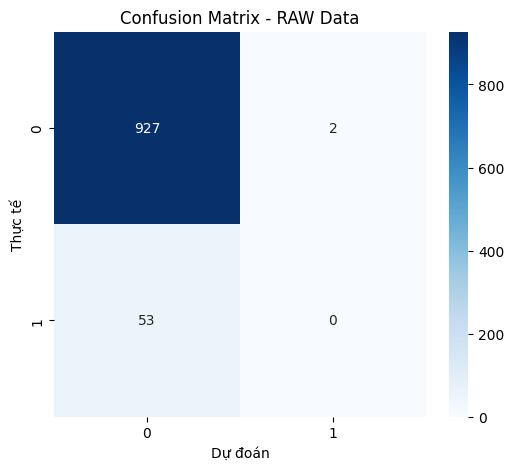

In [8]:
current_dir = Path.cwd()
data_dir = current_dir.parent.parent / "data"
file_name = "healthcare-dataset-stroke-data.csv"
data_path = data_dir / 'raw' / file_name

print("="*50)
print("CHẠY MODEL TRÊN DỮ LIỆU THÔ (RAW DATA)")
print("="*50)

# 1. Load dữ liệu gốc
df = pd.read_csv(data_path)

# 2. Xử lý tối thiểu để code không bị lỗi (Minimal preprocessing)
# Bắt buộc phải bỏ ID vì nó gây nhiễu
df = df.drop(columns=['id'])
# Bắt buộc phải xử lý Missing Value (Drop thẳng tay - cách làm ngây thơ)
df = df.dropna()
# Bắt buộc phải chuyển chữ thành số (One-hot encoding mặc định)
df = pd.get_dummies(df, drop_first=True)

# 3. Chia tập train/test (Random thông thường)
X = df.drop(columns=['stroke'])
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train Model (Logistic Regression mặc định)
# Lưu ý: Không dùng StandardScaler, không dùng class_weight
model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.03,
    scale_pos_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
    n_jobs=-1
)

# Bắt đầu đo thời gian
start = time.time()

model.fit(X_train, y_train)

# 5. Đánh giá
y_pred = model.predict(X_test)

end = time.time()
elapsed_time = end - start

print("\n--- KẾT QUẢ (RAW DATA) ---")
print(classification_report(y_test, y_pred))

# Tính accuracy
acc = accuracy_score(y_test, y_pred)

print("\nMa trận nhầm lẫn:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Vẽ Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - RAW Data')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()

# NHẬN XÉT DỰ KIẾN:
# Accuracy sẽ rất cao (~95%) nhưng Recall của class 1 (Stroke) sẽ cực thấp hoặc bằng 0.
# Lý do: Model thấy 95% dữ liệu là khỏe mạnh, nên nó đoán TOÀN BỘ là khỏe mạnh để an toàn.

In [9]:
output_dir = data_dir / "results"
output_dir.mkdir(exist_ok=True)

report = classification_report(y_test, y_pred, output_dict=True)

df_report = pd.DataFrame(report)

# Thêm accuracy (global) vào dòng riêng
df_report.loc["accuracy"] = [acc, None, None, None, None]

# Thêm thời gian chạy
df_report.loc["time_seconds"] = [elapsed_time, None, None, None, None]

# đặt tên riêng
df_report.to_csv(output_dir / "xgboost_processed_raw.csv")